In [1]:
import os
import json

from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import torch


from bigram_estimator import getWordDict, getNgramDict, pLM
from generate_watermark import load_model, generate
from likelihood_ratio_test import L_Gw

/Users/wayne/miniconda3/envs/lm-watermarking1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = Namespace()

arg_dict = {
    'run_gradio': False, 
    'demo_public': False,
    'model_name_or_path': 'facebook/opt-125m', 
    # 'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    
    # 'use_gpu': True, 
    'use_gpu': False, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 4.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
}

args.__dict__.update(arg_dict)

args.is_seq2seq_model = any([(model_type in args.model_name_or_path) for model_type in ["t5","T0"]])
args.is_decoder_only_model = any([(model_type in args.model_name_or_path) for model_type in ["gpt","opt","bloom"]])


In [4]:
model, tokenizer, device = load_model(args)

In [5]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='facebook/opt-125m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)


In [5]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("hello")

[('hello', (0, 5))]

In [23]:
times = 5 #1000
tokd_input, watermark_processor, output, corpus_without_watermark, corpus_with_watermark, _ = generate("",
                                                                    args,
                                                                    model=model,
                                                                    device=device,
                                                                    tokenizer=tokenizer,
                                                                    times=times)

Generating with Namespace(run_gradio=False, demo_public=False, model_name_or_path='facebook/opt-125m', load_fp16=False, prompt_max_length=200, max_new_tokens=200, generation_seed=123, use_sampling=True, n_beams=1, sampling_temp=0.7, use_gpu=False, seeding_scheme='simple_1', gamma=0.25, delta=2.0, normalizers='', ignore_repeated_bigrams=False, detection_z_threshold=4.0, select_green_tokens=True, skip_model_load=False, seed_separately=True, is_seq2seq_model=False, is_decoder_only_model=True)


To load whole corpora. Only use when analysing over larger corpora

In [5]:
path_watermarked = '/data/corpora_with_watermark/'
json_file_names = [filename for filename in os.listdir(path_watermarked) if filename.endswith('.json')]
# print(json_file_names)
corpus_with_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_watermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_with_watermark += foo

FileNotFoundError: [Errno 2] No such file or directory: '/data/corpora_with_watermark/'

In [53]:
path_nonwatermarked = '/data/corpora_without_watermark/'
json_file_names = [filename for filename in os.listdir(path_nonwatermarked) if filename.endswith('.json')]
corpus_without_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_nonwatermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_without_watermark += foo

In [24]:
word_dict_w = getWordDict(corpus_with_watermark, tokenizer)
n_gram_dict_w = getNgramDict(corpus_with_watermark, tokenizer)

word_dict_nw = getWordDict(corpus_without_watermark, tokenizer)
n_gram_dict_nw = getNgramDict(corpus_without_watermark, tokenizer)

## Computing $\sup_{\theta \in \Theta} L(\theta)$

In [13]:
m = torch.nn.LogSoftmax(dim=1)
input = torch.randn(2,3)
m(input)

tensor([[-0.4242, -1.6224, -1.9086],
        [-0.6533, -2.4814, -0.9262]])

In [60]:

def pLM(word1, tokenizer, soft_next_token_logits):
    # word 1 and word 2 can also be whole sentences, expandable.
    
    word1tok = tokenizer.convert_tokens_to_ids(word1)

    prob = soft_next_token_logits[word1tok]

    return prob

In [65]:
def L_Gw(delta, w, word_dict, watermark_processor, tokenizer, model): 
    Lgrprod = 1
    Ldelta = 0
    expdelta = torch.exp(delta)
    greenlist_w, redlist_w = watermark_processor._get_greenlist_ids(torch.tensor(tokenizer.encode(w)), get_redlist=True)
    greenlist_w = tokenizer.convert_ids_to_tokens(greenlist_w)
    redlist_w = tokenizer.convert_ids_to_tokens(redlist_w)
    
    for word in word_dict.keys():
        greensum = 0 
        redsum = 0
        word2tok = tokenizer.convert_tokens_to_ids(word)
        with torch.inference_mode():
            output = model(torch.tensor([[word2tok]]))
        soft_next_token_logits = torch.softmax(output.logits[0, -1, :], -1) 
        
        for wdash in greenlist_w:
            greensum += pLM(wdash, tokenizer, soft_next_token_logits)

        for wdash in redlist_w:
            redsum += pLM(wdash, tokenizer, soft_next_token_logits)
        
        Lgrprod *= greensum * expdelta + redsum
        if w in greenlist_w:
            Ldelta += delta
    
    L = Ldelta - torch.log(Lgrprod)
    return L

In [62]:
deltaarr = torch.arange(0, 1, 0.01)
# deltaarr
Larr = L_Gw(deltaarr, 'Ġup', word_dict_nw, watermark_processor, tokenizer, model)


In [58]:
Larr

tensor([ 3.6377e-04, -4.4109e-01, -8.8593e-01, -1.3342e+00, -1.7858e+00,
        -2.2409e+00, -2.6994e+00, -3.1614e+00, -3.6269e+00, -4.0959e+00,
        -4.5684e+00, -5.0444e+00, -5.5240e+00, -6.0072e+00, -6.4940e+00,
        -6.9844e+00, -7.4784e+00, -7.9760e+00, -8.4773e+00, -8.9823e+00,
        -9.4910e+00, -1.0003e+01, -1.0520e+01, -1.1039e+01, -1.1563e+01,
        -1.2090e+01, -1.2622e+01, -1.3157e+01, -1.3696e+01, -1.4238e+01,
        -1.4785e+01, -1.5335e+01, -1.5890e+01, -1.6448e+01, -1.7010e+01,
        -1.7576e+01, -1.8146e+01, -1.8720e+01, -1.9298e+01, -1.9880e+01,
        -2.0467e+01, -2.1057e+01, -2.1651e+01, -2.2249e+01, -2.2852e+01,
        -2.3458e+01, -2.4069e+01, -2.4683e+01, -2.5302e+01, -2.5925e+01,
        -2.6552e+01, -2.7184e+01, -2.7819e+01, -2.8459e+01, -2.9103e+01,
        -2.9751e+01, -3.0404e+01, -3.1061e+01, -3.1722e+01, -3.2387e+01,
        -3.3057e+01, -3.3731e+01, -3.4409e+01, -3.5092e+01, -3.5779e+01,
        -3.6470e+01, -3.7166e+01, -3.7866e+01, -3.8

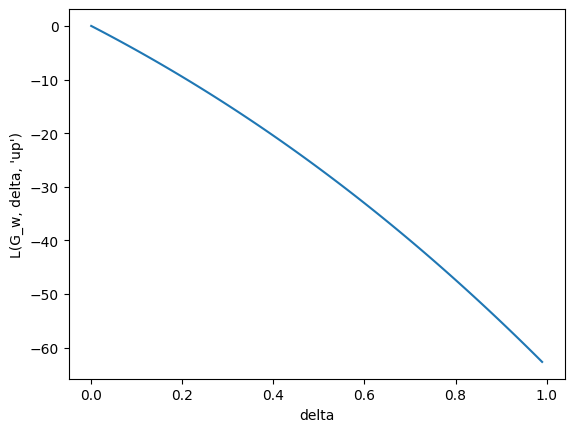

In [63]:
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'up\')")
plt.show()

In [45]:
## L gradient descent

optim = torch.optim.SGD()

tensor([[  113,  1711,    21,   269,  3035,   113,  1437,  1437,    22, 14783,
            38,   218,    75,   216,   932,    59,   930,     8,    38,  3996,
             5,   569,   113,  1437,  1437,    22,   100,   218,    75,   216,
           932,    59,   930,   113,  1437,  1437,    22,  2847,    99,    32,
            47,   608,    19,   110,  1730,  1917,  1437,  1437,    22,   100,
           437,  6908,   120,   106,     7,  3836,   113, 50118,   243,    18,
            67,     5,   275,  2214,    11,     5,  1445,  2642,   328,     2]])
